In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Data Preparation

In [24]:
transform_train = T.Compose([
    T.RandomResizedCrop(32),  # Random cropping the image to 32x32 pixels
    T.RandomHorizontalFlip(),  # Flipping it horizontally
    T.ToTensor(),  # image to tensor
    T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Normalizing using CIFAR-100 dataset statistics
])

transform_val = T.Compose([
    T.Resize(32),  
    T.CenterCrop(32),  
    T.ToTensor(),  
    T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Normalizing for validation set
])


# Load CIFAR-100 dataset for training and validation

In [25]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)  # Loading training data with batch size of 64

valset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)
valloader = DataLoader(valset, batch_size=64, shuffle=False)  # Loading validation data


In [26]:
#Swish Activation Function -----
class Swish(nn.Module):  # custom module for Swish activation function
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)  # Swish = x * sigmoid(x)


# Model Defination

In [27]:
# Defining  the MBConvBlock for the EfficientNet model
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, kernel_size=3):
        super(MBConvBlock, self).__init__()
        hidden_dim = in_channels * expand_ratio  # Hidden layer size --> based on expand ratio
        self.use_res_connect = (stride == 1 and in_channels == out_channels)  # Residual connection 

        # Layers
        self.expand_conv = nn.Conv2d(in_channels, hidden_dim, 1, bias=False)  
        self.bn1 = nn.BatchNorm2d(hidden_dim)  # Batch normalization
        self.dwconv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride, 
                                 padding=kernel_size // 2, groups=hidden_dim, bias=False)  #  convolution-->depthwise
        self.bn2 = nn.BatchNorm2d(hidden_dim)  # Batch normalization step
        self.se = nn.Sequential(  # Squeeze-and-excitation (SE) block
            nn.AdaptiveAvgPool2d(1),  
            nn.Conv2d(hidden_dim, hidden_dim // 4, 1),  # First 1x1 convolution
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim // 4, hidden_dim, 1),  # Second 1x1 convolution
            nn.Sigmoid()  # Sigmoid activation
        )
        self.pwconv = nn.Conv2d(hidden_dim, out_channels, 1, bias=False)  # Pointwise convolution
        self.bn3 = nn.BatchNorm2d(out_channels)  
        self.act = Swish()  # Swish activation

    def forward(self, x):
        out = self.act(self.bn1(self.expand_conv(x)))  # Applying the  expansion convolution + batch norm + activation
        out = self.act(self.bn2(self.dwconv(out)))  # Applying   depthwise convolution + batch norm + activation
        se_out = self.se(out)  
        out = out * se_out  
        out = self.bn3(self.pwconv(out))  # Applying pointwise convolution + batch norm
        if self.use_res_connect:
            out = x + out  # skip connction
        return out

In [28]:
class EfficientNetLite(nn.Module):
    def __init__(self, num_classes=100, width_coeff=1.0, depth_coeff=1.0):
        super(EfficientNetLite, self).__init__()
        base_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]  # Base channel sizes for different stage
        scaled_channels = [int(ch * width_coeff) for ch in base_channels]  # Scaling channels based on width coefficient
        base_depths = [1, 2, 2, 3, 3, 4, 1]  # Number of MBConv blocks per stage

        # Initial stem layer: Conv2d -> BatchNorm -> Activation (Swish)
        self.stem = nn.Sequential(
            nn.Conv2d(3, scaled_channels[0], 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(scaled_channels[0]),
            Swish()
        )
        
        # Building MBConv blocks
        blocks = []
        blocks.append(MBConvBlock(scaled_channels[0], scaled_channels[1], expand_ratio=1, stride=1))  # First MBConv block
        blocks.append(MBConvBlock(scaled_channels[1], scaled_channels[2], expand_ratio=6, stride=2))  # Downsampling
        
        # Repeating the blocks based on depth scaling
        for _ in range(max(0, int(base_depths[1] * depth_coeff) - 1)):
            blocks.append(MBConvBlock(scaled_channels[2], scaled_channels[2], expand_ratio=6, stride=1))
        
        blocks.append(MBConvBlock(scaled_channels[2], scaled_channels[3], expand_ratio=6, stride=2))
        for _ in range(max(0, int(base_depths[2] * depth_coeff) - 1)):
            blocks.append(MBConvBlock(scaled_channels[3], scaled_channels[3], expand_ratio=6, stride=1))
        
        blocks.append(MBConvBlock(scaled_channels[3], scaled_channels[4], expand_ratio=6, stride=2))
        for _ in range(max(0, int(base_depths[3] * depth_coeff) - 1)):
            blocks.append(MBConvBlock(scaled_channels[4], scaled_channels[4], expand_ratio=6, stride=1))
        
        blocks.append(MBConvBlock(scaled_channels[4], scaled_channels[5], expand_ratio=6, stride=1))
        for _ in range(max(0, int(base_depths[4] * depth_coeff) - 1)):
            blocks.append(MBConvBlock(scaled_channels[5], scaled_channels[5], expand_ratio=6, stride=1))
        
        blocks.append(MBConvBlock(scaled_channels[5], scaled_channels[6], expand_ratio=6, stride=2))
        for _ in range(max(0, int(base_depths[5] * depth_coeff) - 1)):
            blocks.append(MBConvBlock(scaled_channels[6], scaled_channels[6], expand_ratio=6, stride=1))
        
        blocks.append(MBConvBlock(scaled_channels[6], scaled_channels[7], expand_ratio=6, stride=1))  # Final MBConv block
        
        self.blocks = nn.Sequential(*blocks)  # Wrapping all blocks in a sequential module
        
        # Head of the network
        self.head = nn.Sequential(
            nn.Conv2d(scaled_channels[7], scaled_channels[8], 1, bias=False),
            nn.BatchNorm2d(scaled_channels[8]),
            Swish()
        )
        
        # Pooling and classification layer
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.dropout = nn.Dropout(0.2)  # Added dropout for regularization
        self.classifier = nn.Linear(scaled_channels[8], num_classes)  

    def forward(self, x):
        x = self.stem(x)  # Passing --> initial convolution stem
        x = self.blocks(x)  # Passing --> MBConv blocks
        x = self.head(x)  # Passing --> final convolution head
        x = self.pool(x)  # Applying global average pooling
        x = x.view(x.size(0), -1)  # Flatten the output for the classifier
        x = self.dropout(x)  # dropout
        x = self.classifier(x)  # final class predictions
        return x

# B0 and B1 model

In [29]:
model_b0 = EfficientNetLite(num_classes=100, width_coeff=1.0, depth_coeff=1.0)  # B0 model
model_b1 = EfficientNetLite(num_classes=100, width_coeff=1.2 ,depth_coeff=1.4)  # Mini B1 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_b0 = model_b0.to(device)  # Moving B0 model to device
model_b1 = model_b1.to(device)  # Moving B1 model to device

# Training step

In [30]:

def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=50):    #--> Training function with loss and accuracy tracking
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()  #training mode
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()  # Update learning rate with scheduler
        epoch_loss = running_loss / len(trainloader)  # Average loss for the epoch
        epoch_acc = 100 * correct / total  # Accuracy for the epoch
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation 
        model.eval()  # evaluation mode
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():  # Disabling the  gradient calculation during validation---> to save memory and computation and to prevent accidental weight changes during evaluation.
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)  # Average validation loss
        val_acc = 100 * correct / total  # Validation accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")
    return train_losses, train_accuracies, val_losses, val_accuracies


In [31]:
# Train B0-like model
print("Training B0-like Model...")
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer_b0 = optim.Adam(model_b0.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler_b0 = CosineAnnealingLR(optimizer_b0, T_max=50)  # Cosine Annealing learning rate scheduler
b0_train_losses, b0_train_accs, b0_val_losses, b0_val_accs = train_model(
    model_b0, trainloader, valloader, criterion, optimizer_b0, scheduler_b0, num_epochs=100)

# Train Mini B1-like model
print("\nTraining Mini B1 Model...")
optimizer_b1 = optim.Adam(model_b1.parameters(), lr=0.001)  # Adam optimizer for B1
scheduler_b1 = CosineAnnealingLR(optimizer_b1, T_max=50)
b1_train_losses, b1_train_accs, b1_val_losses, b1_val_accs = train_model(
    model_b1, trainloader, valloader, criterion, optimizer_b1, scheduler_b1, num_epochs=100)


Training B0-like Model...
Epoch 1/100, Train Loss: 4.2235, Train Acc: 5.66%, Val Loss: 4.0319, Val Acc: 8.48%, LR: 0.000999
Epoch 2/100, Train Loss: 3.9698, Train Acc: 7.94%, Val Loss: 3.8318, Val Acc: 9.45%, LR: 0.000996
Epoch 3/100, Train Loss: 3.8602, Train Acc: 9.58%, Val Loss: 3.7408, Val Acc: 11.13%, LR: 0.000991
Epoch 4/100, Train Loss: 3.8236, Train Acc: 10.27%, Val Loss: 3.8284, Val Acc: 12.12%, LR: 0.000984
Epoch 5/100, Train Loss: 3.8942, Train Acc: 9.50%, Val Loss: 3.6978, Val Acc: 11.76%, LR: 0.000976
Epoch 6/100, Train Loss: 3.8153, Train Acc: 10.60%, Val Loss: 3.6129, Val Acc: 13.61%, LR: 0.000965
Epoch 7/100, Train Loss: 3.7080, Train Acc: 12.20%, Val Loss: 3.4839, Val Acc: 15.50%, LR: 0.000952
Epoch 8/100, Train Loss: 3.7002, Train Acc: 12.66%, Val Loss: 3.5152, Val Acc: 14.67%, LR: 0.000938
Epoch 9/100, Train Loss: 3.6624, Train Acc: 13.22%, Val Loss: 3.3942, Val Acc: 17.25%, LR: 0.000922
Epoch 10/100, Train Loss: 3.7138, Train Acc: 12.28%, Val Loss: 3.3822, Val Acc: 

# graph plot

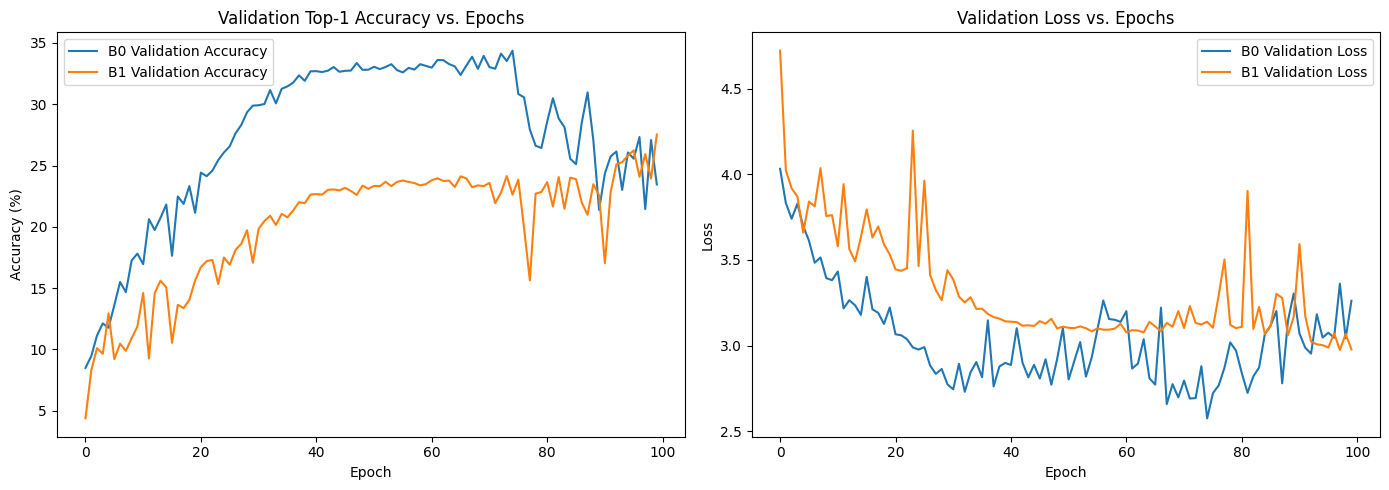

In [ ]:
plt.figure(figsize=(14, 5))  # Plotting the evaluation metrics for both models
# Accuracy comparison plot
plt.subplot(1, 2, 1)
plt.plot(b0_val_accs, label='B0 Validation Accuracy')
plt.plot(b1_val_accs, label='B1 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Top-1 Accuracy vs. Epochs')
plt.legend()

# Loss comparison plot
plt.subplot(1, 2, 2)
plt.plot(b0_val_losses, label='B0 Validation Loss')
plt.plot(b1_val_losses, label='B1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.tight_layout()
plt.show()  

# Discussion

# EfficientNet Training Results

## B0 Model:
- **Final Validation Top-1 Accuracy**: 23.46% (Epoch 100)
- **Final Validation Loss**: 3.2620
- **Training Accuracy (Epoch 100)**: 19.61%
- **Peak Validation Accuracy**: 34.37% (Epoch 75)

### Observations:
- B0 starts with a validation accuracy of **8.48% at Epoch 1** and improves steadily, peaking at **34.37% by Epoch 75**.
- After Epoch 75, there’s a noticeable decline in validation accuracy, dropping to **23.46% by Epoch 100**, while training accuracy remains relatively stable (**around 28-29% until Epoch 75, then dropping to 19.61%**).
- Validation loss decreases initially (**from 4.0319 to 2.5759 by Epoch 75**) but shows significant fluctuations and an **upward trend after Epoch 75**, reaching **3.2620 by the end**.

---

## B1 Model:
- **Final Validation Top-1 Accuracy**: 27.53% (Epoch 100)
- **Final Validation Loss**: 2.9782
- **Training Accuracy (Epoch 100)**: 21.92%
- **Peak Validation Accuracy**: 27.53% (Epoch 100)

### Observations:
- B1 starts with a lower validation accuracy of **4.37% at Epoch 1** but shows a **more consistent upward trend**, reaching **27.53% by Epoch 100**.
- Training accuracy improves steadily from **4.42% to 21.92% over 100 epochs**, with **fewer drastic drops compared to B0**.
- Validation loss decreases from **4.7212 to 2.9782**, with fluctuations but a **more stable trend compared to B0, especially after Epoch 50**.


## 2. Comparison of B0 vs. B1  

### Accuracy:  
#### Early Training (Epochs 1-50):  
- **B0 outperforms B1 significantly** in the first 50 epochs.  
- At **Epoch 50**, B0 achieves a **validation accuracy of 32.82%**, while B1 is at **23.10%**.  
- This suggests **B0 learns faster initially**, likely due to its **simpler architecture** (`width_coeff=1.0`, `depth_coeff=1.0`), which may **converge more quickly on a smaller parameter space**.  

#### Later Training (Epochs 51-100):  
- **B1 catches up and surpasses B0 after Epoch 50**.  
- By **Epoch 100**, B1’s validation accuracy is **27.53%**, compared to B0’s **23.46%**.  
- B1’s **higher capacity** (`width_coeff=1.2`, `depth_coeff=1.4`) and **dropout (0.2)** likely help it **generalize better in the later stages**, avoiding the sharp decline seen in B0.  

#### Peak Performance:  
- **B0 peaks at 34.37% (Epoch 75)**, higher than **B1’s peak of 27.53% (Epoch 100)**.  
- However, **B0’s peak is not sustained**, indicating **potential overfitting**, while **B1’s performance is more stable and ends higher**.  

---

### Loss:  
#### B0 Validation Loss:  
- **Shows high volatility**, especially after Epoch 50, with **spikes** (e.g., `3.3618` at Epoch 98) and a **final value of 3.2620**.  
- The **initial decrease** (to `2.5759` by Epoch 75) followed by an **increase** suggests **overfitting**, as the model **fails to generalize well after a certain point**.  

#### B1 Validation Loss:  
- **Also fluctuates** but **trends downward more consistently**, ending at `2.9782`.  
- While there are **spikes** (e.g., `4.2549` at Epoch 24), **B1’s loss stabilizes better than B0’s**, indicating **improved generalization**.  


# Bonus

### Question 1

### 1.1 What is the advantage of using `nn.Embedding` over manually creating one-hot vectors for each token? In what scenarios might manual one-hot encoding still be viable?
  
Using `nn.Embedding` is much more efficient compared to manually creating one-hot vectors. One-hot encoding creates very sparse vectors with only one '1' in a sea of '0's, which can lead to a lot of memory usage, especially for large vocabularies. With `nn.Embedding`, each token is mapped to a dense, learnable vector, which allows the model to better capture relationships between words and is much more memory-efficient.  
However, in small problems with very limited vocabulary and when the overhead of learning embeddings isn’t justified, manual one-hot encoding might still be acceptable for simplicity.


### 1.2 What is `self.dropout()`? When and where can we use dropout?
  
`self.dropout()` is a regularization technique used to prevent overfitting by randomly setting some of the input elements to zero during training. It forces the model to not rely too heavily on any one feature, improving generalization. Dropout can be used after any layer where overfitting might be a concern, like after the embedding layer or even before the output layer in deep models. It’s especially useful when training models on small datasets or very complex models.


## Question 2

### 2.1 How exactly does PyTorch handle backpropagation through all these timesteps?
 
PyTorch handles backpropagation through the timesteps in a way that makes it efficient for sequence models. For each timestep in a sequence, the model calculates the gradients and stores them in a computational graph. During the backward pass, PyTorch will automatically apply backpropagation through each timestep in reverse order. This means it updates the parameters (weights) based on the error at each step, making it easier to train models like RNNs that work with sequences.


## Question 3

### 3.1 Why do we use `nn.LogSoftmax(dim=1)` instead of `nn.Softmax`? How does this choice affect the loss function that we use during training?
  
We use `nn.LogSoftmax` instead of `nn.Softmax` because it’s more numerically stable when combined with `nn.NLLLoss` (negative log-likelihood loss). Softmax outputs probabilities, but applying the log to these probabilities before passing them into the loss function avoids issues with very small numbers, making training more stable. The log conversion also directly aligns with how `nn.NLLLoss` expects the input, which improves the efficiency and performance of the model during training